In [8]:
import numpy as np 
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from geopy.geocoders import Nominatim
from tqdm import tqdm
import requests
from collections import deque
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import pyplot as plt
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim 

import requests
from pandas.io.json import json_normalize

!conda install -c conda-forge folium=0.5.0 --yes
import folium # our main map rendering library

print('Libraries imported.')

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\EngMo\AppData\Local\Continuum\anaconda3

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.21.0               |             py_0          58 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          92 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.21.0-py_0




geopy-1.21.0         | 58 KB     |            |   0%
geopy-1.21.0         | 58 KB     | ##7        |  27%
geopy-1.21.0         | 58 KB     | #####4     |  55%
geopy-1.21.0         | 58 KB     | ########## | 100%

geograp

In [16]:
import pandas as pd

df_data_1 = pd.read_csv('wijken_buurten.csv')
df_data_1 = df_data_1.drop([0], axis=0)

df_data_1.head()

,subject,region_name,regio_type,region_code,ninhabitants,nmen,nwomen,nage_0_to_15,nage_15_to_25,nage_25_to_45,nage_45_to_65,nage_65_older,nunmarried,nmarried,ndivorced,nwidowed,nimmigrant_western,nimmigrant_nonwestern,nimmigrant_marokko,nimmigrant_antiles_aruba,nimmigrant_surinam,nimmigrant_turkey,nimmigrant_other_non_western,nhouseholds,nhh_single_person,nhh_no_children,nhh_with_children,ave_househ_size,populatio_density,area_total,area_land,area_water,urbanisation_grade,address_density,geojson,lon,lat
1,Burgwallen-Oude Zijde,Amsterdam,Wijk,WK036300,4280,2340,1935,255,675,2030,980,355,3280,660,290,65,1275,640,25,40,80,40,455,3070,2160,655,265,1.4,12255.0,40,35,6,1.0,7619.0,"{""type"": ""FeatureCollection"",""crs"": { ""type"": ...",4.896943,52.372566
2,Kop Zeedijk,Amsterdam,Buurt,BU03630000,1020,570,445,50,140,520,260,60,765,175,70,15,320,145,5,10,20,10,105,740,520,170,55,1.4,16818.0,8,6,2,1.0,6649.0,"{""type"": ""FeatureCollection"",""crs"": { ""type"": ...",4.900280,52.375937
3,Oude Kerk e.o.,Amsterdam,Buurt,BU03630001,670,365,300,30,130,320,145,55,540,70,55,15,205,105,5,10,15,10,70,500,370,95,45,1.3,7615.0,9,9,0,1.0,7361.0,"{""type"": ""FeatureCollection"",""crs"": { ""type"": ...",4.896156,52.373793
4,Burgwallen Oost,Amsterdam,Buurt,BU03630002,1610,880,730,120,250,755,340,155,1230,255,115,25,495,275,10,15,35,10,210,1120,770,260,105,1.4,25867.0,7,6,1,1.0,7544.0,"{""type"": ""FeatureCollection"",""crs"": { ""type"": ...",4.898757,52.372815
5,Nes e.o.,Amsterdam,Buurt,BU03630003,370,185,180,25,70,195,65,25,300,50,20,5,120,35,5,0,5,5,25,270,205,55,20,1.4,6939.0,6,5,0,1.0,9825.0,"{""type"": ""FeatureCollection"",""crs"": { ""type"": ...",4.893728,52.370861


In [17]:
# get the coordinates of Amsterdam
address = 'Amsterdam, Nederland'

geolocator = Nominatim(user_agent="my-application")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Amsterdam, Nederland {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Amsterdam, Nederland 52.3727598, 4.8936041.


In [18]:
# group neighbourhoods by coordinates
n_clusters = 10
neigbourhoods_grouped = KMeans(n_clusters=n_clusters, random_state=0).fit(df_data_1[['lat', 'lon']])
neigbourhoods_grouped.cluster_centers_

array([[52.35418413,  4.8981259 ],
       [52.3656447 ,  4.99573439],
       [52.35477417,  4.81402566],
       [52.35873673,  4.93480968],
       [52.35146221,  4.86206048],
       [52.3084988 ,  4.97114465],
       [52.39572502,  4.93289053],
       [52.37687063,  4.84651167],
       [52.37696239,  4.78780509],
       [52.38700674,  4.88262484]])

In [19]:
def find_nearest_neighbourhood(centroids, lat, long):
    return np.argmin(np.linalg.norm(centroids - [lat, long], axis = 1)) + 1

In [20]:
# define Foursquare Credentials and Version
CLIENT_ID = 'J0M4JG11FIGT12BVT1PVEDRUPP3RNKVQHJBRU5GWHP2FKVRM' # your Foursquare ID
CLIENT_SECRET = 'XNPREDSKCVE0I1NBHXISFBIJJ0UY10VHGYAMAFLHQGAME4CU' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
radius = 500
LIMIT = 250

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: J0M4JG11FIGT12BVT1PVEDRUPP3RNKVQHJBRU5GWHP2FKVRM
CLIENT_SECRET:XNPREDSKCVE0I1NBHXISFBIJJ0UY10VHGYAMAFLHQGAME4CU


In [21]:

# Ams is a huge city with tons of buurts and wijks (neighbourhoods in Dutch), so we have to limit 
# the scope of our search. Let's focus on top-30 coffeeshops and then see which belongs to which neighbourhood.
# Import Requests
import requests

# Import BeautifulSoup
from bs4 import BeautifulSoup
# Use the Requests get method to request the top coffeeshops in Ams
page = requests.get(
    "https://4sq.com/2w53vf2")

# Convert the HTML response into a BeautifulSoup Object
soup = BeautifulSoup(page.content, 'html.parser')

# Use the BeautifulSoup find_all method to extract each top site venue details.
top_venues = soup.find_all('div', class_='venueDetails')

In [22]:
# The column names for the top venues dataframe
venue_columns = ['id', 
                 'score', 
                 'category', 
                 'name', 
                 'address',
                 'postalcode',
                 'city',
                 'href', 
                 'latitude', 
                 'longitude',
                 'n_cluster']

# Create the empty top venues dataframe
df_top_venues = pd.DataFrame(columns=venue_columns)
# For each venue in the BeautifulSoup HTML object
for venue in top_venues:
    
    # Extract the available attributes
    venue_name = venue.find(target="_blank").get_text()
    venue_score = venue.find(class_="venueScore positive").get_text()
    venue_cat = venue.find(class_="categoryName").get_text()
    venue_href = venue.find(class_="venueName").h2.a['href']
    venue_id = venue_href.split('/')[-1]

    if 'promotedTipId' in venue_id: 
        continue
        
    # Contruct the FourSquare venue API URL
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(
        venue_id, 
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION)
    
    # Request the venue data
    result = requests.get(url).json()
    #print(result)
        
    # Get the properly formatted address and the latitude and longitude
    venue_address = result['response']['venue']['location']['address']
    venue_postalcode = result['response']['venue']['location']['postalCode']
    venue_city = result['response']['venue']['location']['city']
    venue_latitude = result['response']['venue']['location']['lat']
    venue_longitude = result['response']['venue']['location']['lng']
    n_cluster = find_nearest_neighbourhood(neigbourhoods_grouped.cluster_centers_,
                                           venue_latitude,
                                           venue_longitude)
    # Add the venue to the top venues dataframe
    df_top_venues = df_top_venues.append({'id': venue_id,
                                          'score': venue_score,
                                          'category': venue_cat,
                                          'name': venue_name,
                                          'address': venue_address,
                                          'postalcode': venue_postalcode,
                                          'city': venue_city,
                                          'href': venue_href,
                                          'latitude': venue_latitude,
                                          'longitude': venue_longitude,
                                          'n_cluster': n_cluster}, ignore_index=True)

In [23]:
# The score type needs to be converted to float
df_top_venues['score'] = pd.to_numeric(df_top_venues['score'], errors='coerce').fillna(0)

# Describe the score to see if there is nuch variance in the values
df_top_venues.score.describe()

count    30.000000
mean      8.416667
std       0.536967
min       7.300000
25%       8.100000
50%       8.500000
75%       8.700000
max       9.400000
Name: score, dtype: float64

In [24]:
# verify the content of df_top_venues
df_top_venues.head()

,id,score,category,name,address,postalcode,city,href,latitude,longitude,n_cluster
0,4a2705a4f964a52052881fe3,8.7,Аптека марихуаны,Grey Area Coffeeshop,Oude Leliestraat 2,1015 AW,Amsterdam,/v/grey-area-coffeeshop/4a2705a4f964a52052881fe3,52.374641,4.888839,10
1,4bff1a50480eef3b4f6e9e7f,8.6,Аптека марихуаны,Coffeeshop Amsterdam IBIZA,Hemonystraat 16,1074 BP,Amsterdam,/v/coffeeshop-amsterdam-ibiza/4bff1a50480eef3b...,52.357405,4.902060,1
2,4a270064f964a52051831fe3,8.7,Аптека марихуаны,De Dampkring,Handboogstraat 29,1012 XM,Amsterdam,/v/de-dampkring/4a270064f964a52051831fe3,52.367759,4.890478,1
3,4a270344f964a520f3841fe3,8.2,Аптека марихуаны,Coffeeshop Easy Times,Prinsengracht 476,1017 KG,Amsterdam,/v/coffeeshop-easy-times/4a270344f964a520f3841fe3,52.364452,4.885096,1
4,4a2700c1f964a5204e841fe3,8.1,Аптека марихуаны,Barney's Uptown,Haarlemmerstraat 105,1013 EW,Amsterdam,/v/barneys-uptown/4a2700c1f964a5204e841fe3,52.380768,4.890645,10


In [25]:
# backup (in case the API doesn't doesn't allow to access it)
df_top_venues.to_csv('./top_venues.csv')

In [26]:
# The column names for the restaurants dataframe
restaurants_columns = ['id',
                       'score', 
                       'category', 
                       'categoryID', 
                       'name', 
                       'address',
                       'postalcode',
                       'city',
                       'latitude',
                       'longitude', 
                       'venue_name', 
                       'venue_latitude',
                       'venue_longitude',
                       'n_cluster']

In [27]:
# Create the empty top venues dataframe
df_restaurant = pd.DataFrame(columns=restaurants_columns)

# Create a list of all the top venue latitude and longitude
top_venue_lats = df_top_venues['latitude'].values
top_venue_lngs = df_top_venues['longitude'].values

# Create a list of all the top venue names
top_venue_names = df_top_venues['name'].values

# Iterate over each of the top venues
# The venue name, latitude and longitude are passed to the loop
for ven_name, ven_lat, ven_long in zip(top_venue_names, top_venue_lats, top_venue_lngs):
    
    # Configure additional Search parameters
    # This is the FourSquare Category Id for all food venues
    categoryId = '4d4b7105d754a06374d81259'
    radius = 500
    limit = 10
    
    # Contruct the FourSquare search API URL
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}' \
          '&v={}&categoryId={}&radius={}&limit={}'.format(
        CLIENT_ID,
        CLIENT_SECRET,
        ven_lat,
        ven_long,
        VERSION,
        categoryId,
        radius, 
        limit)
    
    # Make the search request
    results = requests.get(url).json()
     # Populate the new dataframe with the list of restaurants
    # Get the values for each Restaurant from the JSON
    for restaurant in results['response']['venues']:
 
        # Sometimes the Venue JSON is missing data. If so ignore and continue
        try:
            # Get location details
            rest_id = restaurant['id']
            rest_category = restaurant['categories'][0]['pluralName']
            rest_categoryID = restaurant['categories'][0]['id']
            rest_name = restaurant['name']
            rest_address = restaurant['location']['address']
            rest_postalcode = restaurant['location']['postalCode']
            rest_city = restaurant['location']['city']
            rest_latitude = restaurant['location']['lat']
            rest_longitude = restaurant['location']['lng']
            
            # Contruct the FourSquare venue API URL to get the venues rating / score
            rest_url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(
                rest_id, 
                CLIENT_ID,
                CLIENT_SECRET,
                VERSION)
            
            # Get the restaurant score and href
            result = requests.get(rest_url).json()
            #print(result)
            rest_score = result['response']['venue']['rating']
            n_cluster = find_nearest_neighbourhood(neigbourhoods_grouped.cluster_centers_,
                                                   rest_latitude,
                                                   rest_longitude)            
            # Add the restaurant details to the dataframe
            df_restaurant = df_restaurant.append({'id': rest_id,
                                                  'score': rest_score,
                                                  'category': rest_category,
                                                  'categoryID': rest_categoryID,
                                                  'name': rest_name,
                                                  'address': rest_address,
                                                  'postalcode': rest_postalcode,
                                                  'city': rest_city,
                                                  'latitude': rest_latitude,
                                                  'longitude': rest_longitude,
                                                  'venue_name': ven_name,
                                                  'venue_latitude': ven_lat,
                                                  'venue_longitude': ven_long,
                                                  'n_cluster': n_cluster,
                                                  }, ignore_index=True)
            
        # If there are any issue with a restaurant ignore and continue
        except Exception as e:
            print(type(e), e)

<class 'KeyError'>'postalCode'
<class 'KeyError'>'postalCode'
<class 'KeyError'>'rating'
<class 'KeyError'>'postalCode'
<class 'KeyError'>'postalCode'
<class 'KeyError'>'postalCode'
<class 'KeyError'>'address'
<class 'KeyError'>'venue'
<class 'KeyError'>'postalCode'
<class 'KeyError'>'address'
<class 'KeyError'>'rating'
<class 'KeyError'>'address'
<class 'KeyError'>'postalCode'
<class 'KeyError'>'postalCode'
<class 'KeyError'>'postalCode'
<class 'KeyError'>'postalCode'


In [28]:
# backup restaurants
df_restaurant.to_csv('./restaurants.csv')
# set color scheme for the clusters
colors_array = cm.rainbow(np.linspace(0, 1, n_clusters))
#colors_array = cm.rainbow(np.random.sample(n_clusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

In [29]:

def add_markers(city_map, latitudes, longitudes, colors, names, 
                radius = 5, fill_color = 'blue', fill_opacity = 0.7):
    for lat, lng, color, name in zip(latitudes, longitudes, colors, names):
        label = '{}'.format(name)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=radius,
            popup=label,
            label=name,
            color=color,
            fill=True,
            fill_color=fill_color,
            fill_opacity=fill_opacity).add_to(city_map)

In [30]:
# show neighbourhood clusters
map_ams = folium.Map(location=[latitude, longitude], zoom_start=11)
add_markers(map_ams, 
            neigbourhoods_grouped.cluster_centers_[:,0],
            neigbourhoods_grouped.cluster_centers_[:,1],
            [rainbow[i] for i in range(neigbourhoods_grouped.n_clusters)],
            range(neigbourhoods_grouped.n_clusters),
            radius = 10,
            fill_color = 'blue',
            fill_opacity = 0.1)  
add_markers(map_ams,
            df_data_1['lat'],
            df_data_1['lon'],
            [rainbow[i] for i in neigbourhoods_grouped.labels_],
            range(len(df_data_1)),
            radius = 1
           )
map_ams

In [31]:
# save the map as HTML file
map_ams.save('map_ams_nh.html')

In [32]:
# show coffeeshops and restaurants on the same map

map_ams = folium.Map(location=[latitude, longitude], zoom_start=11)

add_markers(map_ams, 
            df_restaurant['latitude'],
            df_restaurant['longitude'],
            [rainbow[i - 1] for i in df_restaurant['n_cluster']],
            ['Restaurant: {}, Cluster {}'.format(name, n) 
             for n, name in zip(df_restaurant['n_cluster'], df_restaurant['name'])],
            radius = 5,
            fill_color = 'red')    

add_markers(map_ams, 
            df_top_venues['latitude'],
            df_top_venues['longitude'],
            [rainbow[i - 1] for i in df_top_venues['n_cluster']],
            ['Coffeeshop: {}, Cluster {}'.format(name, n) 
             for n, name in zip(df_top_venues['n_cluster'], df_top_venues['name'])],
             radius = 5,
            fill_color = 'green')    

map_ams

In [33]:
# save the map as HTML file
map_ams.save('map_ams_cf_and_rest.html')

In [34]:
def draw_hist(obj, column):
    axis = obj.hist(by = 'n_cluster', column = column)
    for i in np.ndindex(axis.shape):
        ax = axis[i]
        ax.set_title('Cluster {}'.format(ax.get_title()))
        ax.set_xlabel(column)
        ax.set_ylabel('N')
    plt.tight_layout()

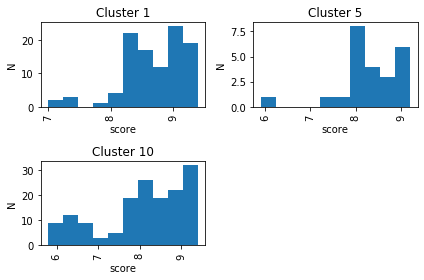

In [35]:
draw_hist(df_restaurant, 'score')

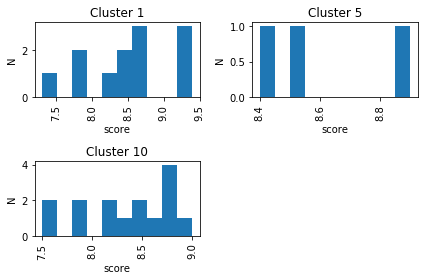

In [36]:
draw_hist(df_top_venues, 'score')
